## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Import python libraries.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

import folium
from folium import plugins
from folium.plugins import HeatMap

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import geopandas as gpd

from shapely.geometry import Polygon, mapping
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import csv
from pylab import *

import branca
import branca.colormap as cm


import xgboost
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

## Importing data and EDTA

In [2]:
# Importing data
folder_name = 'data/'
data_file_name = 'training_set.csv'
labels_file_name = 'training_set_labels.csv'
test_file_name = 'training_set_labels.csv'
df_raw = pd.read_csv(folder_name + data_file_name, index_col = 0)
df_labels = pd.read_csv(folder_name + labels_file_name, index_col = 0)


#Geodata
shp_folder_name = 'data/shape_files/'
district_shp_file ='tza_admbnda_adm2_20181019.shp'
region_shp_file ='tza_admbnda_adm1_20181019.shp'
gdf_district = gpd.read_file(shp_folder_name + district_shp_file)
gdf_region = gpd.read_file(shp_folder_name + region_shp_file)

df_raw.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


* Create geographical points for each water wall.

In [3]:
points = list(zip(df_raw['longitude'],df_raw['latitude']))

df_raw['geo_points'] = [Point(points[point]) for point in range(len(points))]

* Convert 'region_code' and 'district_code' to same format as the corrected columns.

In [4]:
def int_to_str(column):
    temp = []
    for i in range(len(column)):
        num_str = str(column.iloc[i])
        if len(num_str) == 1:
            temp.append('0' + num_str)
        else:
            temp.append(num_str)
    return temp

In [5]:
df_raw['region_str'] = int_to_str(df_raw['region_code'])
df_raw['region_str'] = 'TZ' + df_raw['region_str']
df_raw['dist_str'] = int_to_str(df_raw['district_code'])
df_raw['reg-dis_str'] = df_raw['region_str'] + df_raw['dist_str']

df_raw.drop(['dist_str','region_code','district_code'], axis = 1, inplace = True)

In [6]:
df_raw = df_raw.fillna('unknown')

In [7]:
df_raw.isna().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
g

## Correcting 'region_code' and 'district_code' based on region and district geodata

In [8]:
#This function will take each waterwall coordinates and evaluate them true if within the shape polygon.

def reg_dis_corrections(dataframe, geodata, criteria, column_name):
    points = list(zip(dataframe['longitude'],dataframe['latitude']))
    
    for point in range(len(points)):
        for region in range(geodata.shape[0]):
            if Point(points[point]).within(geodata.iloc[region]['geometry']):
                dataframe.at[dataframe.index[point], column_name] = geodata.iloc[region][criteria]   

In [9]:
# Correct the district code from the imported data with the shape polygons.

# df_raw['district_corrected'] = df_raw['reg-dis_str']
# reg_dis_corrections(df_raw, gdf_district, 'ADM2_PCODE', 'district_corrected')
# df_raw['district_corrected'].to_csv(shp_folder_name + 'train_district_corrected.csv')

train_district_corrected = pd.read_csv(shp_folder_name + 'train_district_corrected.csv')
df_raw['district_corrected'] = list(train_district_corrected['district_corrected'])
df_raw.drop(['reg-dis_str'], axis = 1, inplace = True)

In [10]:
# Correct the region code from the imported data with the shape polygons.

# %%time
# CPU times: user 5min 58s, sys: 694 ms, total: 5min 59s
# Wall time: 8min 2s
    
# df_raw['region_corrected'] = df_raw['region_str']
# reg_dis_corrections(df_raw, gdf_region, 'ADM1_PCODE', 'district_corrected')
# df_raw['region_corrected'].to_csv(shp_folder_name + 'train_region_corrected.csv')

train_region_corrected = pd.read_csv(shp_folder_name + 'train_region_corrected.csv')
df_raw['region_corrected'] = list(train_region_corrected['region_corrected'])
df_raw.drop(['region_str'], axis = 1, inplace = True)

In [11]:
df_raw.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,geo_points,district_corrected,region_corrected
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,POINT (34.93809275 -9.856321769999999),TZ2205,TZ11
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,POINT (34.6987661 -2.14746569),TZ2002,TZ20
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,POINT (37.46066446 -3.82132853),TZ2104,TZ21
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,POINT (38.48616088 -11.15529772),TZ0906,TZ90
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,POINT (31.13084671 -1.82535885),TZ1801,TZ18


## Converting dataset from multi-class to binary class

In [12]:
df_labels = df_labels.replace('functional needs repair', 'functional')

## Creating a new feature, 'age'

In [13]:
df_raw['age'] = 2020 - df_raw['construction_year']

* Merging the features into the master dataframe

In [14]:
df = pd.concat([df_labels, df_raw], axis=1, sort=False)

* Converting the features into integers for mapping colors.

In [15]:
labels = {
    'non functional': 0,
    'functional': 1,
}

df['functional_index'] = [labels[water_well] for water_well in df['status_group']] 

In [16]:
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,geo_points,district_corrected,region_corrected,age,functional_index
id,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,spring,spring,groundwater,communal standpipe,communal standpipe,POINT (34.93809275 -9.856321769999999),TZ2205,TZ11,21,1
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,POINT (34.6987661 -2.14746569),TZ2002,TZ20,10,1
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,dam,dam,surface,communal standpipe multiple,communal standpipe,POINT (37.46066446 -3.82132853),TZ2104,TZ21,11,1
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,POINT (38.48616088 -11.15529772),TZ0906,TZ90,34,0
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,POINT (31.13084671 -1.82535885),TZ1801,TZ18,2020,1


# Visuals

* Create a new metric that will calculate the percentage of a feature, in this case it will be 'status_group' within a given zone ('region_corrected' or 'district_corrected').

In [17]:
def percent(dataframe, column, group_by, features, drop):
    
    df_group_by = dataframe.groupby([group_by])[column].value_counts(normalize = True)

    for feature in features:
        dataframe[str(group_by + "_" + feature)] = [df_group_by[well][feature] 
                                 if feature in set(df_group_by[well].index) else 0
                                 for well in dataframe[group_by]]        
    
    
    if drop:
        dataframe.drop(group_by, axis = 1, inplace = True)
        
    return dataframe

In [18]:
# Map Dataframe
columns = [
    'status_group',
    'geo_points',
    'district_corrected',
    'region_corrected',
    'functional_index',
    'latitude',
    'longitude']

df_map = df[columns].copy()
df_map.head()

,status_group,geo_points,district_corrected,region_corrected,functional_index,latitude,longitude
id,,,,,,,
69572,functional,POINT (34.93809275 -9.856321769999999),TZ2205,TZ11,1,-9.856322,34.938093
8776,functional,POINT (34.6987661 -2.14746569),TZ2002,TZ20,1,-2.147466,34.698766
34310,functional,POINT (37.46066446 -3.82132853),TZ2104,TZ21,1,-3.821329,37.460664
67743,non functional,POINT (38.48616088 -11.15529772),TZ0906,TZ90,0,-11.155298,38.486161
19728,functional,POINT (31.13084671 -1.82535885),TZ1801,TZ18,1,-1.825359,31.130847


In [19]:
%%time
# features_to_percent = ['functional','non functional','functional needs repair']
features_to_percent = ['functional']
columns_to_percents = [                   
    'region_corrected',
    'district_corrected',
]

for target in columns_to_percents:
    percent(df_map, 'status_group', target, features_to_percent, False)

CPU times: user 38.4 s, sys: 314 ms, total: 38.7 s
Wall time: 38.6 s


In [20]:
df_map.head()

,status_group,geo_points,district_corrected,region_corrected,functional_index,latitude,longitude,region_corrected_functional,district_corrected_functional
id,,,,,,,,,
69572,functional,POINT (34.93809275 -9.856321769999999),TZ2205,TZ11,1,-9.856322,34.938093,0.804906,0.794326
8776,functional,POINT (34.6987661 -2.14746569),TZ2002,TZ20,1,-2.147466,34.698766,0.480447,0.629888
34310,functional,POINT (37.46066446 -3.82132853),TZ2104,TZ21,1,-3.821329,37.460664,0.684144,0.570370
67743,non functional,POINT (38.48616088 -11.15529772),TZ0906,TZ90,0,-11.155298,38.486161,0.318430,0.265823
19728,functional,POINT (31.13084671 -1.82535885),TZ1801,TZ18,1,-1.825359,31.130847,0.611613,0.620948


In [21]:
# Defining a function to import a dataframe with well data, longitudinal and latitudinal coordinates and plot
# on folium with a heatmap feature on the functionality of the well.

def water_well_map(dataframe, zoom):
    x_start = dataframe['latitude'].median()
    y_start = dataframe['longitude'].median()
    start_coord = (x_start, y_start)

    #You can pick one of these toners to have a different effect on the map.
    tiles=['Stamen Terrain','Stamen Toner']
    tiles=tiles[0]

    map = folium.Map(location=start_coord, zoom_start=zoom,tiles=tiles, width=1000, height=2000)

    lat = list(dataframe.latitude)
    lon = list(dataframe.longitude)
    functional = list(dataframe.functional_index)

    colormap = cm.LinearColormap(
        colors=['red','green'], 
        index=[0, 1],
        vmin=0,vmax=2)

    for loc, f in zip(zip(lat, lon), functional):
        folium.Circle(
            location=loc,
            radius = 0.1,
            fill = True,
            color = colormap(f),
            fill_opacity = 1
        ).add_to(map)

    display(map)

In [22]:
# water_well_map(df_map, 6.5)

In [23]:
# Create a function for folium choropleth scaling to add to geodata dataframe
def map_gradients(geo_df, data_df):
    geo_df['data'] = float(0)
    geo_df['index'] = geo_df[geo_df.columns[-3]]
    geo_df.set_index('index',inplace = True)

    for t in data_df.index:
        geo_df.at[t,'data'] = data_df[t]

    geo_df.dropna(inplace = True)
    
    return geo_df

In [24]:
# Create a function to map the data either per region or per district.
def map_plot(dataframe, map_data, legend_name, zoom):
    x_start = dataframe['latitude'].median()
    y_start = dataframe['longitude'].median()
    mymap = folium.Map(location=[x_start, y_start], zoom_start=zoom,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
    mymap
    
    myscale = (map_data['data'].quantile((0,0.25,0.5, 0.75,1))).tolist()
    mymap.choropleth(
     geo_data=map_data,
     name='Choropleth',
     data=map_data,
     columns=[map_data.columns[-3],map_data.columns[-1]],
     key_on= str("feature.properties." + map_data.columns[-3]),
     fill_color='YlGnBu',
     threshold_scale=myscale,
     fill_opacity=1,
     line_opacity=0.2,
     legend_name=legend_name,
     smooth_factor=0
    )
    return mymap

In [25]:
zone_map = [[gdf_region,'region_corrected'], [gdf_district,'district_corrected']]

In [26]:
# plot = zone_map[1]
# map_plot(df_map, 
#          map_gradients(plot[0], df.groupby([plot[1]])['status_group'].count()),
#         'Well density per ' + plot[1],
#          zoom = 6)

In [27]:
# Create a function to return the percents of the feature called for mapping.
def map_group_by(dataframe, sort_by, feature):
    
    feature = sort_by + "_" + feature
    
    columns = [
        sort_by,
        feature
    ]
    
    temp = dataframe[columns]
    temp.drop_duplicates(inplace = True)
    temp.set_index(sort_by,inplace = True)
    return pd.Series(temp[feature])

In [28]:
# plot = zone_map[1]
# map_plot(df_map, 
#          map_gradients(
#              plot[0], 
#              map_group_by(df_map, 
#              plot[1], 
#              'functional')
#          ),
#         'Well percent functioning per ' + plot[1],
#          zoom = 6)

# Analysis of features

In [29]:
# Create a new copy of the cleaned df dataframe
df_model = df.copy()
df_model['age'] = 2020 - df_model['construction_year']
df_model.drop(['functional_index','construction_year'], axis = 1, inplace = True)

In [30]:
#Create a function to plot a histogram of a feature showing 'functional/non functional' weights
def histogram_plot(data, sort_by):
    labels = list(data.groupby([sort_by])['status_group'].count().index)
    functional = list(data[df['status_group'] =='functional'].groupby([sort_by])['status_group'].count())
    non_functional = list(data[data['status_group'] =='non functional'].groupby([sort_by])['status_group'].count())

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(14,7))
    rects1 = ax.bar(x - width/2, functional, width, label='Functional', color = "skyblue")
    rects2 = ax.bar(x + width/2, non_functional, width, label='Non Functional', color = "lightgray")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Well counts')
    ax.set_title('Number of wells by category: ' + sort_by)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

In [31]:
# Delete unneeded features for the model

columns_to_delete = ['amount_tsh',
                    'region',
                     'wpt_name',
                     'num_private',
                     'basin',
                     'subvillage',
                     'public_meeting',
                     'scheme_management',
                     'scheme_name',
                     'permit',
                     'date_recorded',
                     'extraction_type',
                     'extraction_type_group',
                     'management_group',
                     'payment_type',
                     'quality_group',
                     'waterpoint_type',
                     'quantity_group',
                     'source_class',
                     'gps_height',
                     'recorded_by',
                     'geo_points',
                     'source',
                     'longitude',
                     'latitude'
                    ]

df_model.drop(columns_to_delete, axis = 1, inplace = True)

In [32]:
# Create a function to calculate the percent functional of a given categorical feature

def percent(dataframe, column, group_by, features):
    df_group_by = dataframe.groupby([group_by])[column].value_counts(normalize = True)
    for feature in features:
        dataframe[str(group_by + "_" + feature)] = [df_group_by[well][feature] 
                                 if feature in set(df_group_by[well].index) else 0
                                 for well in dataframe[group_by]]        
    return dataframe

In [33]:
%%time
# Will use this for competition when all 3 categories will be used.
# features_to_percent = ['functional','non functional','functional needs repair']
features_to_percent = ['functional']
columns_to_percents = [                   
    'lga',                      
    'ward',                     
    'management',               
    'payment',                  
    'water_quality',            
    'quantity',                 
    'source_type',              
    'waterpoint_type_group',    
    'region_corrected',
    'district_corrected',
    'extraction_type_class',
    'funder',
    'installer'
]

for target in columns_to_percents:
    percent(df_model, 'status_group', target, features_to_percent)

df_features = df_model.copy()

df_model.drop(columns_to_percents, axis = 1, inplace = True)
    
new_columns = list(df_model.columns[-1*(len(columns_to_percents) * len(features_to_percent)):])

df_model.head()

CPU times: user 3min 53s, sys: 1.52 s, total: 3min 55s
Wall time: 3min 54s


,status_group,population,age,lga_functional,ward_functional,management_functional,payment_functional,water_quality_functional,quantity_functional,source_type_functional,waterpoint_type_group_functional,region_corrected_functional,district_corrected_functional,extraction_type_class_functional,funder_functional,installer_functional
id,,,,,,,,,,,,,,,,
69572,functional,109,21,0.794326,0.638889,0.573136,0.820154,0.642764,0.724643,0.697256,0.660477,0.804906,0.794326,0.700112,0.854545,0.680851
8776,functional,280,10,0.629888,0.647887,0.698542,0.524144,0.642764,0.619076,0.740741,0.660477,0.480447,0.629888,0.700112,0.811321,0.846154
34310,functional,250,11,0.597403,0.900000,0.573136,0.723317,0.642764,0.724643,0.422256,0.660477,0.684144,0.570370,0.700112,1.000000,0.786765
67743,non functional,58,34,0.265823,0.187500,0.573136,0.524144,0.642764,0.031060,0.537869,0.660477,0.318430,0.265823,0.579705,0.661306,0.576577
19728,functional,0,2020,0.588846,0.846154,0.663507,0.524144,0.642764,0.676790,0.740741,0.660477,0.611613,0.620948,0.700112,1.000000,0.600000


In [34]:
#Defining a function that will create new bins of a column based on a list of parameters.

def d_bin_prep(column, parameters):
    bin_prep = [0] * len(column)
    param_len = len(parameters)
    for item in range(len(column)):
        i = 0
        for param in range(param_len):
            if column.iloc[item] >= parameters[param]:
                bin_prep[item] += 1
            else:
                break
    
    bin_prep = [x - 1 for x in bin_prep]
    return bin_prep

In [35]:
bin_parameters = {
#     'non functional': [0.6],
#     'functional': [0.6, 0.65],
    'age': [5, 10, 15, 20, 30, 40, 60],
    'lga_functional': [0.5,0.65],
    'ward_functional': [0.4, 0.6],
    'payment_functional': [0.6],
    'quantity_functional': [0.6],
    'management_functional': [0.6],
    'source_type_functional': [0.65],
    'waterpoint_type_group_functional': [0.6],
    'region_corrected_functional': [0.5, 0.65],
    'district_corrected_functional': [0.3, 0.4, 0.6],
    'extraction_type_class_functional':[0.3],
    'population':[1],
    'installer_functional': [0.45],
    'funder_functional': [0.45],
    'water_quality_functional': [0.65]

}

In [36]:
%%time
# Create bins for each of the features listed in the bin_parameters dictionary.
features = list(bin_parameters.keys())

new_features = []
for feature in features:
    parameters = bin_parameters[feature]
    df_model[feature + "_bin"] = d_bin_prep(df_model[feature], parameters)
    new_features.append(feature + "_bin")

df_model.drop(features, axis = 1, inplace = True)

df_model = pd.get_dummies(df_model, columns=new_features, drop_first = True)

CPU times: user 7.56 s, sys: 29.9 ms, total: 7.59 s
Wall time: 7.63 s


In [37]:
# This function will return the percent for each feature of the column inputed in the dataframe.
def percent_rank(dataframe, column):
    columns = [column,
               str(column + '_functional')]
    temp = dataframe[columns]
    temp.drop_duplicates(inplace = True)
    temp.set_index(column,inplace = True)

    return temp

In [38]:
# This function will create a histogram of the percentage features and the bin split used in the model.
def feature_hist(df, feature, bins):
    
    fig = plt.figure(figsize=(14,7))
    ax = fig.add_axes([0,0,1,1])
    data = percent_rank(df, feature)
    data.sort_values(feature + '_functional',inplace=True)
    labels = list(data.index)
    label_values = list(data[feature + '_functional'])
    
    ax.barh(labels,label_values, color='skyblue',linewidth=0.2,)

    ax.set_xlabel('percent functional')
    ax.set_title('Percent of functional wells by category: ' + feature)
    
    for line in bins[feature + '_functional']:
        axvline(x=line)
    
    plt.show()

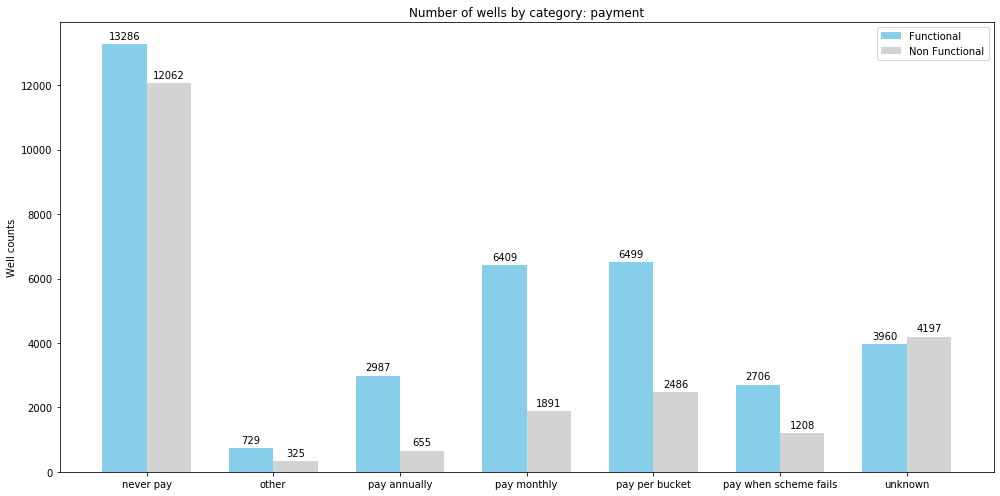

In [39]:
histogram_plot(df, 'payment')

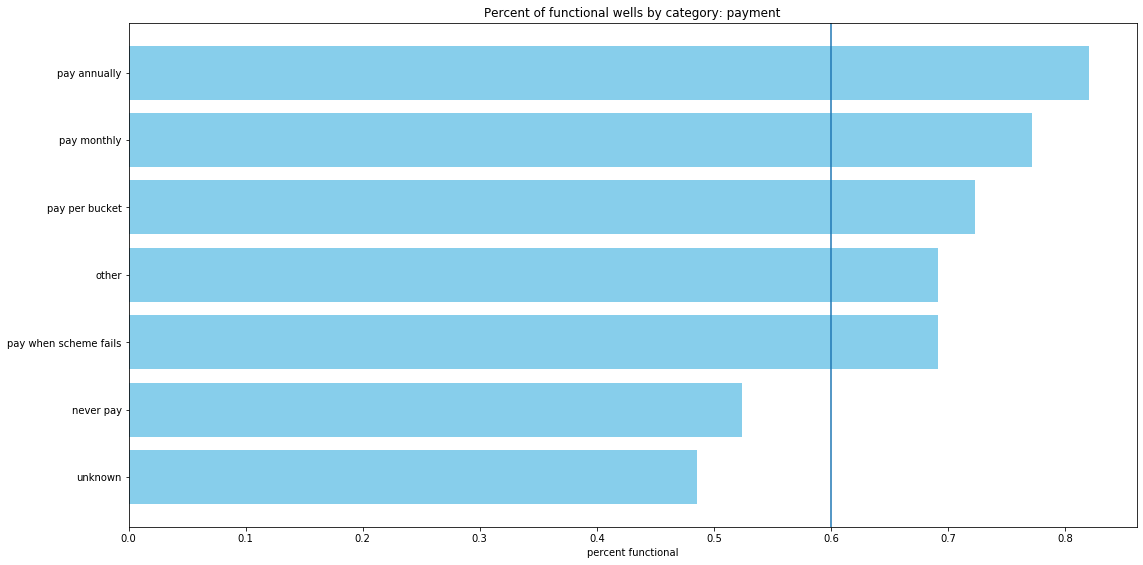

In [40]:
feature_hist(df_features, 'payment', bin_parameters)

#  Model

In [41]:
# Define the X and Y features.

X = df_model.loc[:, df_model.columns[1:]]
X = pd.get_dummies(X, drop_first = True)
Y = df_model[df_model.columns[0]]

# Create train-test split for validation of logistic regression model.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [42]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
Y_train = encoder.transform(y_train)
Y_test = encoder.transform(y_test)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
%%time

modelxgb = XGBClassifier(objective = 'binary:logistic', booster = 'gbtree', 
                      eval_metric = 'error', eta = .1,
                      max_depth = 50, colsample_bytree = .4)

modelxgb.fit(X_train, y_train)

y_train_pred = modelxgb.predict(X_train)
y_test_pred = modelxgb.predict(X_test)

print("Training set score for SVM: %f" % accuracy_score(y_train, y_train_pred))
print("Testing set score for SVM: %f" % accuracy_score(y_test, y_test_pred))

Training set score for SVM: 0.838361
Testing set score for SVM: 0.825926
CPU times: user 15 s, sys: 67.9 ms, total: 15 s
Wall time: 1.94 s


In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(classification_report(y_test, y_test_pred))

                precision    recall  f1-score   support

    functional       0.82      0.92      0.87      9172
non functional       0.84      0.68      0.75      5678

      accuracy                           0.83     14850
     macro avg       0.83      0.80      0.81     14850
  weighted avg       0.83      0.83      0.82     14850



(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

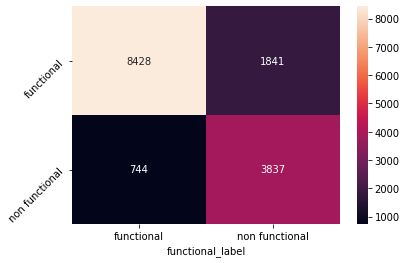

In [46]:
mat_grid_new = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat_grid_new.T, annot=True, fmt='g',
           xticklabels = ['functional', 'non functional'],
           yticklabels = ['functional', 'non functional'])


plt.xlabel('functional_label')
plt.yticks(rotation = 45)

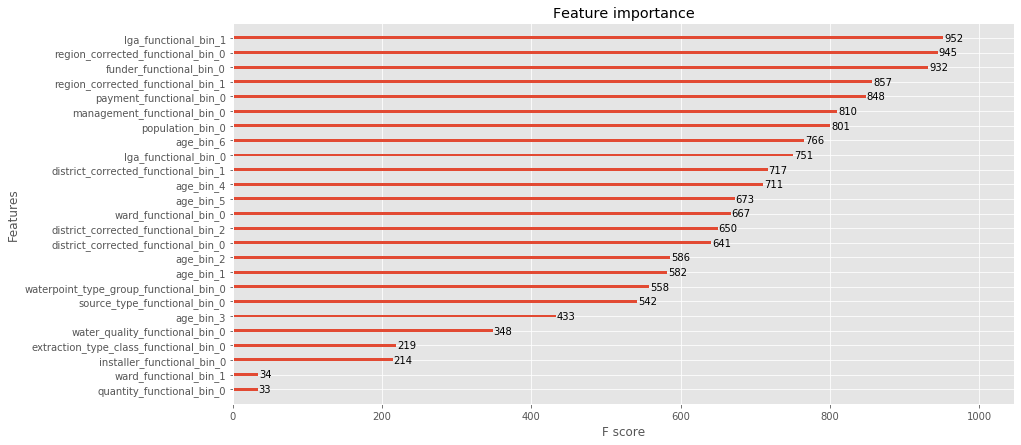

In [47]:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1,1, figsize=(14,7))
xgboost.plot_importance(modelxgb._Booster, ax = ax1)